# 6장 추천엔진 만들기 (Updated)

데이터: [Anime Recommendation Database 2020](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv)

## 바이인코더와 크로스인코더 비교

Q: 바이인코더와 크로스인코더를 비교해줘

A: 바이인코더와 크로스 인코더는 자연어 처리에서 문장 쌍의 관계를 모델링하는 데 사용되는 두 가지 주요 아키텍처입니다. 다음은 두 아키텍처의 비교입니다:

1. 구조 및 동작 방식:
- 바이인코더: 두 개의 독립적인 인코더를 사용하여 각 문장을 별도로 처리합니다. 인코딩된 벡터 사이의 유사도를 계산하여 문장 쌍의 관계를 판단합니다.
- 크로스 인코더: 두 문장을 하나의 시퀀스로 연결하여 단일 인코더에 전달합니다. 인코더의 출력을 기반으로 문장 쌍의 관계를 예측하는 분류기를 사용합니다.

2. 추론 속도:
- 바이인코더: 각 문장을 독립적으로 인코딩하므로 추론 속도가 빠릅니다. 대규모 코퍼스에 대한 유사도 계산이 효율적입니다.
- 크로스 인코더: 각 문장 쌍마다 인코더를 통과해야 하므로 추론 속도가 상대적으로 느립니다. 대규모 코퍼스에 대한 유사도 계산은 비효율적일 수 있습니다.

3. 정확도:
- 바이인코더: 문장 간 상호작용을 직접 모델링하지 않으므로, 정확도가 크로스 인코더에 비해 다소 낮을 수 있습니다.
- 크로스 인코더: 문장 간 상호작용을 직접 모델링하므로, 문장 쌍의 관계를 보다 정확하게 예측할 수 있습니다.

4. 메모리 사용량:
- 바이인코더: 각 문장에 대한 임베딩 벡터를 저장해야 하므로, 메모리 사용량이 크로스 인코더에 비해 높을 수 있습니다.
- 크로스 인코더: 각 문장 쌍을 개별적으로 처리하므로, 메모리 사용량이 바이인코더에 비해 낮습니다.

5. 적용 분야:
- 바이인코더: 대규모 코퍼스에 대한 유사도 계산, 의미 검색, 개체명 연결 등의 태스크에 적합합니다.
- 크로스 인코더: 문장 쌍의 관계를 보다 정확하게 예측해야 하는 태스크(예: 자연어 추론, 의미 유사도 계산)에 적합합니다.

두 아키텍처는 각각의 장단점이 있으므로, 태스크의 특성과 요구 사항에 따라 적절한 아키텍처를 선택해야 합니다. 경우에 따라서는 두 아키텍처를 조합하여 사용하기도 합니다. 예를 들어, 바이인코더를 사용하여 후보 문장을 필터링한 후, 크로스 인코더를 사용하여 최종 순위를 결정하는 방식 등이 있습니다.

# 1. 초기화 및 데이터 로딩

## 1.1 초기화

In [1]:
BASE_DIR = ""

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
###########################################
# 1-1. Google drive mount

if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    
    BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/quick-start-guide-to-llms/notebooks/"

In [4]:
# !pip install sentence-transformers openai==0.28.1 datasets

In [5]:
from collections import defaultdict
import concurrent.futures
from functools import partial, lru_cache
import pandas as pd
from openai import OpenAI
import os
import json

from transformers import RobertaTokenizer
import random
from datasets import load_dataset
import itertools
import numpy as np
from torch.utils.data import DataLoader
import re
import string
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, evaluation, losses, InputExample

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

random.seed(42)

## 1.2 애니메이션 정보 데이터 로딩

In [6]:
pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv').dropna()
# pre_merged_anime = pd.read_csv('https://raw.githubusercontent.com/sinanuozdemir/quick-start-guide-to-llms/main/data/pre_merged_anime.csv').dropna()
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [7]:
import re
import string

def clean_text(text):
    # 인쇄할 수 없는 문자 제거
    text = ''.join(filter(lambda x: x in string.printable, text))
    
    # 여러 개의 공백 문자를 하나의 공백으로 바꾸기
    text = re.sub(r'\s{2,}', ' ', text).strip()

    return text.strip()


def get_anime_description(anime_row):
    """
    입력 데이터의 다양한 기능을 기반으로 애니메이션 제목에 대한 사용자 지정 설명을 생성합니다.

    :param anime_row: 관련 애니메이션 정보가 포함된 MyAnimeList 데이터 세트의 행입니다.
    :return: 애니메이션에 대한 사용자 지정 설명이 포함된 형식화된 문자열입니다.
    """

    # 애니메이션 유형(TV 프로그램 또는 기타)을 결정합니다.
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # 입력 데이터의 관련 기능을 사용하여 형식이 지정된 설명을 작성합니다.
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
        f"Its genres are {anime_row['Genres']}\n"
    )

    return clean_text(description)

In [8]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [9]:
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)

In [10]:
pre_merged_anime

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis,generated_description
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever...",Cowboy Bebop is a TV Show.\nSynopsis: In the y...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ...",Cowboy Bebop: Tengoku no Tobira is a Movie.\nS...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Spring 1998,Victor Entertainment,Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,558913,12944,343492,25465,"Vash the Stampede is the man with a $$60,000,0...",Trigun is a TV Show.\nSynopsis: Vash the Stamp...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,94683,587,46165,5121,ches are individuals with special powers like ...,Witch Hunter Robin is a TV Show.\nSynopsis: ch...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Fall 2004,"TV Tokyo, Dentsu",Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,13224,18,7314,766,It is the dark century and the people are suff...,Bouken Ou Beet is a TV Show.\nSynopsis: It is ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,ONA,Unknown,Unknown,Unknown,Unknown,Novel,Unknown,Unknown,Unknown,354,6,0,0,No synopsis information has been added to this...,Daomu Biji Zhi Qinling Shen Shu is a ONA.\nSyn...
16202,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,TV,Unknown,Unknown,Kadokawa,Passione,Manga,Unknown,Unknown,Unknown,7010,70,0,14,ko is a typical high school student whose life...,Mieruko-chan is a TV Show.\nSynopsis: ko is a ...
16203,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,TV,Unknown,Summer 2021,Unknown,Unknown,Visual novel,Unknown,R - 17+ (violence & profanity),Unknown,11309,48,0,0,Sequel to Higurashi no Naku Koro ni Gou .,Higurashi no Naku Koro ni Sotsu is a TV Show.\...
16204,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,TV,Unknown,Unknown,Kadokawa,8bit,Manga,Unknown,PG-13 - Teens 13 or older,Unknown,1386,2,2,2,New Yama no Susume anime.,Yama no Susume: Next Summit is a TV Show.\nSyn...


## 1.3 평점 데이터 로딩

In [11]:
dataset = load_dataset("profoz/anime_rating_complete")
rating_complete = dataset['train'].to_pandas().dropna()
print(rating_complete.shape)

(57633278, 3)


In [12]:
rating_complete.head(20)

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
5,0,431,8
6,0,578,10
7,0,433,6
8,0,1571,10
9,0,121,9


In [13]:
# 사용자 평점 점수를 매기는 맵 만들기.
# 10과 9는 긍정(1), 8과 7은 중립(0), 그 외는 모두 부정(-1)으로 간주됩니다.
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}

rating_complete['nps_score'] = rating_complete['rating'].map(score_map)

# 가장 양극화된 의견을 얻기 위해 NPS가 0인 평가를 삭제합니다.
# 이 기능을 유지해야 한다는 주장도 있지만 저는 유지하지 않기로 했습니다. 마음에 들지 않더라도 걱정하지 마세요 :)
rating_complete = rating_complete[rating_complete['nps_score'] != 0]

print(rating_complete.shape)
rating_complete.head(2)

(29665573, 4)


,user_id,anime_id,rating,nps_score
0,0,430,9,1
1,0,1004,5,-1


In [14]:
# median_reviews 미만인 애니메이션이 있는 모든 행을 제거합니다.
median_reviews = rating_complete.groupby('anime_id').count()['rating'].quantile(.90)
print(median_reviews)
animes_with_enough_reviews = rating_complete.groupby('anime_id').count()['rating'] >= median_reviews

rating_complete = rating_complete[rating_complete['anime_id'].isin(animes_with_enough_reviews[animes_with_enough_reviews].index)]

print(rating_complete.shape)
rating_complete.head(2)

4110.0
(22183562, 4)


,user_id,anime_id,rating,nps_score
0,0,430,9,1
1,0,1004,5,-1


## 1.4 평점 데이터 분할
`rating_complete` 데이터를 훈련 세트와 테스트 세트로 분할하는 역할을 합니다. 자세한 설명은 다음과 같습니다:

1. `rating_complete.sample(frac=1, random_state=42)`은 `rating_complete` 데이터프레임을 무작위로 섞습니다.
   - `frac=1`은 전체 데이터프레임을 샘플링한다는 의미입니다. 즉, 데이터프레임의 모든 행을 포함합니다.
   - `random_state=42`는 무작위 섞기의 시드(seed) 값을 설정합니다. 이렇게 하면 코드를 다시 실행해도 동일한 결과를 얻을 수 있습니다.

2. `int(.9*len(rating_complete))`은 전체 데이터의 90%에 해당하는 인덱스를 계산합니다.
   - `len(rating_complete)`은 `rating_complete` 데이터프레임의 총 행 수를 반환합니다.
   - `.9`를 곱하여 전체 데이터의 90%에 해당하는 개수를 계산합니다.
   - `int()`로 감싸서 정수로 변환합니다.

3. `np.split(rating_complete.sample(frac=1, random_state=42), [int(.9*len(rating_complete))])`은 섞인 데이터프레임을 90%와 10%로 분할합니다.
   - `np.split()` 함수는 첫 번째 인자로 분할할 배열 또는 데이터프레임을 받고, 두 번째 인자로 분할 지점을 리스트 형태로 받습니다.
   - `[int(.9*len(rating_complete))]`은 전체 데이터의 90%에 해당하는 인덱스를 리스트로 전달합니다.
   - 이렇게 하면 `np.split()` 함수는 섞인 데이터프레임을 90%와 10%로 분할하여 두 개의 데이터프레임을 반환합니다.

4. 분할된 두 개의 데이터프레임은 `rating_complete_train`과 `rating_complete_test` 변수에 할당됩니다.
   - `rating_complete_train`은 전체 데이터의 90%를 포함하는 훈련 세트가 됩니다.
   - `rating_complete_test`는 전체 데이터의 나머지 10%를 포함하는 테스트 세트가 됩니다.

이 코드는 데이터를 무작위로 섞은 후, 훈련 세트와 테스트 세트로 분할하는 일반적인 데이터 분할 방법을 구현한 것입니다. 훈련 세트는 모델을 학습시키는 데 사용되고, 테스트 세트는 학습된 모델의 성능을 평가하는 데 사용됩니다. 일반적으로 훈련 세트와 테스트 세트의 비율은 8:2 또는 9:1로 설정하며, 이 코드에서는 9:1의 비율로 분할하고 있습니다.

In [15]:
rating_complete_train, rating_complete_test = \
              np.split(rating_complete.sample(frac=1, random_state=42),
                       [int(.9*len(rating_complete))])

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [16]:
rating_complete_train.head()

,user_id,anime_id,rating,nps_score
1077792,6894,2251,9,1
31931743,196193,22789,9,1
31005293,190471,1015,9,1
49436353,303017,2476,6,-1
37205674,228438,20583,9,1


In [17]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(19965205, 4)
(2218357, 4)


In [18]:
# 데이터 프레임을 anime_id로 그룹화하고 각 애니메이션에 해당하는 행 수를 계산합니다.
anime_counts = rating_complete_train.groupby('anime_id').count()

anime_counts['user_id'].describe()

count      1685.000000
mean      11848.786350
std       11668.782929
min        3684.000000
25%        5128.000000
50%        7741.000000
75%       13760.000000
max      110640.000000
Name: user_id, dtype: float64

In [19]:
# 데이터 프레임을 anime_id로 그룹화하고 각 애니메이션에 해당하는 행 수를 계산합니다.
user_counts = rating_complete_train.groupby('user_id').count()

user_counts['anime_id'].describe()

count    306006.000000
mean         65.244489
std          69.315504
min           1.000000
25%          19.000000
50%          45.000000
75%          87.000000
max        1409.000000
Name: anime_id, dtype: float64

# 2. 콘텐츠 임베딩을 사용하여 타이틀 추천하기

## 2.1 초기화, 자카드 유사도 함수 정의

In [20]:
# 모든 애니메이션 쌍 간의 자카드 유사도 계산하기
anime_ids = sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique()))

# 가능한 모든 애니메이션 쌍의 목록을 만듭니다(중복 없이).
anime_pairs = list(itertools.combinations(anime_ids, 2))

# 중복 제거
anime_pairs = list([tuple(sorted(pair)) for pair in anime_pairs])

# 좋은 측정을 위해 애니메이션 쌍 목록을 섞습니다(다음 셀에서 샘플링하기 때문에 실제로는 필요하지 않음).
random.shuffle(anime_pairs)

print(len(anime_pairs))

1408681


In [21]:
SAMPLE = 10_000
if SAMPLE:
    anime_pairs = random.sample(anime_pairs, SAMPLE)

In [22]:
# 부정적인 애니메이션 쌍은 사람들이 동의하지 않는 것으로 간주합니다.
# 높은 (임계값) %의 사람들이 a1을 추천하고 a2를 비방하므로 사용자가 다른 애니메이션에 '좋아요'를 눌렀을 때 한 쪽을 추천하지 않습니다.

def anime_pair_scores(a1, a2):
    a = rating_complete_train[rating_complete_train['anime_id'].isin([a1, a2])]
    a = a[a['nps_score'] != 0]
    if a.shape[0] < 50:  # need at least 50 rows
        return None

    # user_id 열에 중복이 있는 행만 유지합니다.
    a = a[a.duplicated(subset=['user_id'], keep=False)].sort_values('user_id')
    # print(a.groupby('user_id')['nps_score'].apply(sorted).value_counts())

    anime_pair_scores = a.groupby('user_id', group_keys=True)['nps_score'].apply(sorted)

    two_scores = anime_pair_scores[anime_pair_scores.isin([[-1, 1], [1, 1]])].value_counts(normalize=True)
    if len(two_scores) != 2:
        return None
    disagree_score, positively_agree_score = two_scores.sort_index().tolist()  # [-1, 1], [1, 1]
    # 반환 불일치_점수, 긍정적으로_동의_점수

    if positively_agree_score > disagree_score:
        # print(f'{a1} and {a2} are similar')
        return positively_agree_score
    else:
        # print(f'{a1} and {a2} are dissimilar')
        return -1 * disagree_score
    return disagree_score, positively_agree_score

In [23]:
a1, a2 = 4059, 10793
anime_pair_scores(a1, a2)

0.6993894993894993

## 2.2 자카트 유사도를 이용한 긍정/부정 데이터 판별 및 데이터 생성

In [24]:
'''
이 스크립트는 각 예제가 한 쌍의 애니메이션으로 구성된 트레이닝 예제를 준비합니다.
'''
# 양수 및 음수 쌍 예제를 저장하기 위한 빈 목록 초기화하기
positive_pairs_examples, negative_pairs_examples = [], []
considered_pairs = {}
all_scores = []

unique_mal_ids = set(pre_merged_anime['MAL_ID'].unique())

# 결과의 재현성을 보장하기 위해 랜덤 함수의 시드 값을 설정합니다.
random.seed(42)

# 각 애니메이션 쌍 반복
for a1, a2 in tqdm(anime_pairs):
    # 쌍의 애니메이션 중 하나라도 pre_merged_anime 데이터프레임 인덱스에서 찾을 수 없는 경우 현재 반복을 건너뜁니다.
    if a1 not in unique_mal_ids or a2 not in unique_mal_ids:
        continue

    # 애니메이션 a1과 애니메이션 a2를 좋아하는 사용자 집합 간의 Jaccard 유사도 계산하기
    j = anime_pair_scores(a1, a2)
    all_scores.append(j)
    text_pair = pre_merged_anime[pre_merged_anime['MAL_ID'].isin([a1, a2])]['generated_description'].tolist()

    # Jaccard 유사도가 0이 아닌 경우(즉, 일부 공통 사용자가 있는 경우)
    if j is not None:
        # Jaccard 유사도가 0.7보다 크거나 같으면, 
        # 쌍이 긍정적인 예시로 간주되어 positive_pairs_examples 목록에 추가됩니다.
        if j >= 0.7:
            positive_pairs_examples.append(InputExample(texts=text_pair, label=j))

        # Jaccard 유사도가 -0.7 미만인 경우, 
        # 해당 쌍은 부정적인 예시로 간주되어 negative_pairs_examples 목록에 추가됩니다.
        elif j < -0.7:
            negative_pairs_examples.append(InputExample(texts=text_pair, label=j))


  0%|          | 0/10000 [00:00<?, ?it/s]

(count    9999.000000
 mean        0.124397
 std         0.661339
 min        -0.979381
 25%        -0.603391
 50%         0.553191
 75%         0.680458
 max         0.997061
 dtype: float64,
 <Axes: >)

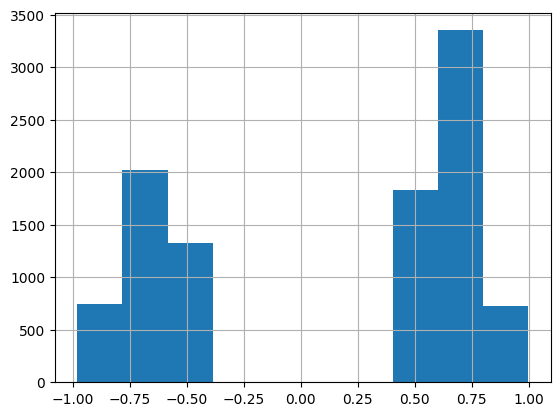

In [25]:
# 놀랍지 않게도, 0점인 NPS 점수를 모두 제거했으므로 사람들이 동의하거나 동의하지 않는 경향이 있는 다중 모드 분포가 나옵니다.)
pd.Series(all_scores).describe(), pd.Series(all_scores).hist()

In [26]:
# 데이터가 많지 않은 것처럼 보일 수 있지만 때로는 이 정도면 충분할 때도 있습니다!
len(positive_pairs_examples), len(negative_pairs_examples)

(2141, 1417)

In [27]:
positive_pairs_examples[0].__dict__  # example of a positive pair

{'guid': '',
 'texts': ['Kuroko no Basket: Tip Off is a Special.\nSynopsis: Episode 22.5 bundled with BD/DVD volume 8. The episode covers Kuroko\'s past, when he was part of the "Generation of Miracles."\nIt was produced by Bandai Visual, Lantis and it is from Production I.G Studio.\nIts source is Manga.\nIt premiered in Unknown.\nIts genres are Sports, Comedy, School, Shounen',
  "Haikyuu!!: To the Top is a TV Show.\nSynopsis: fter their triumphant victory over Shiratorizawa Academy, the Karasuno High School volleyball team has earned their long-awaited ticket to nationals. As preparations begin, genius setter Tobio Kageyama is invited to the All-Japan Youth Training Camp to play alongside fellow nationally recognized players. Meanwhile, Kei Tsukishima is invited to a special rookie training camp for first-years within the Miyagi Prefecture. Not receiving any invitations himself, the enthusiastic Shouyou Hinata feels left behind. However, Hinata does not back down. Transforming his fr

In [28]:
negative_pairs_examples[0].__dict__  # example of a negative pair

{'guid': '',
 'texts': ["Diamond no Ace is a TV Show.\nSynopsis: h a stray pitch that completely missed the batter, Eijun Sawamura loses his final middle school baseball game. Frustrated by this defeat, Eijun and his teammates vow to reach the national tournament once they are in high school. But everything changes when a scout unexpectedly invites him to Tokyo's prestigious Seidou High School after seeing the potential in his unusual pitching style. Encouraged by his teammates, Eijun accepts the offer, ready to improve his skills and play at a much more competitive level of baseball. However, now surrounded by a large number of skilled players, Eijun struggles to find his place on the team. He declares that he will one day become the team's ace, but that's only if fellow first year Satoru Furuya doesn't take the title first, with his breakneck fastballs that earn him a coveted spot on the starting roster. With the addition of these talented new players to an already powerful lineup, t

## 2.3 훈련용과 검증용 데이터 분리

In [29]:
# 별도로 분할하면 분할을 약간 더 세분화할 수 있습니다.
train_positive_pairs, val_positive_pairs = train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)

# 양수 및 음수 쌍 결합
train_examples = train_positive_pairs + train_negative_pairs

# 유효성 검사 세트의 양수 및 음수 쌍 결합하기
val_examples = val_positive_pairs + val_negative_pairs

# 3. paraphrase-distilroberta-base-v1 튜닝

## 3.1 모델 초기화

In [30]:
# 사전 학습된 SBERT 모델 로드
anime_encoder = SentenceTransformer('paraphrase-distilroberta-base-v1')
anime_encoder.max_seq_length = 384     # 컨텍스트 창을 384 토큰으로 변경합니다. 일반적으로 128입니다.

# non-fast tokenizer를 생성합니다. 참고 모델을 저장할 때 순전히 호환성을 위해 이 작업을 수행합니다.
non_fast_tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
anime_encoder.tokenizer = non_fast_tokenizer

anime_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

## 3.2 데이터 분석 및 학습 데이터 생성

In [31]:
lengths = []
for c in pre_merged_anime['generated_description']:
    lengths.append(anime_encoder.tokenizer(c, return_tensors='pt')['input_ids'].shape[1])

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


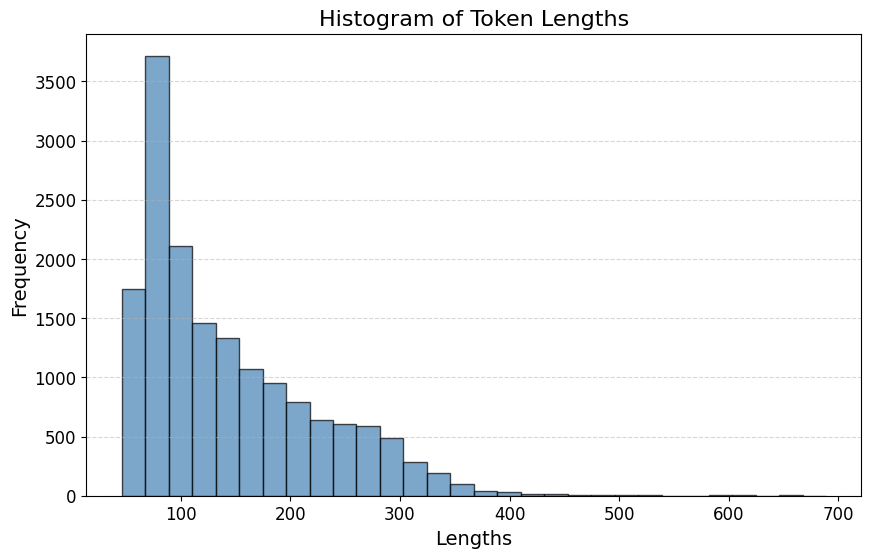

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

plt.title("Histogram of Token Lengths", fontsize=16)
plt.xlabel("Lengths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.show()

In [33]:
# 유효성 검사 예제를 위한 데이터로더 생성
val_dataloader = DataLoader(
    val_examples,
    batch_size=16,
    shuffle=True
)

# 유효성 검사 예제에서 문장 및 점수 추출
val_sentences1 = [ex.texts[0] for ex in val_examples]
val_sentences2 = [ex.texts[1] for ex in val_examples]
val_scores = [ex.label for ex in val_examples]

# 평가자 만들기
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores)

## 3.3 튜닝 전 모델 성능 측정

In [34]:
# 원래 아키텍처는 제한이 128이므로 너무 많은 컨텍스트가 잘립니다.
SentenceTransformer('paraphrase-distilroberta-base-v1').evaluate(evaluator)

0.06880321077699852

In [35]:
# 공정하게 말하면 둘 다 꽤 나쁩니다.
anime_encoder.evaluate(evaluator)

0.14746975002767876

## 3.4 모델 학습

In [36]:
# 훈련용 데이터로더 생성
train_dataloader = DataLoader(
    train_examples,
    batch_size=16,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=anime_encoder)

# 모델 훈련 설정
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

In [37]:
# # 트레이닝
# anime_encoder.fit(
#     train_objectives=[(train_dataloader, loss)],
#     epochs=num_epochs,
#     warmup_steps=warmup_steps,
#     evaluator=evaluator,
#     output_path=BASE_DIR + "anime_encoder_new"
# )

## 3.5 모델 성능 측정 및 저장

In [38]:
# anime_encoder.evaluate(evaluator)  # 0.4045718691531177

In [39]:
# # fine-tuned 모델 저장
# anime_encoder.save(BASE_DIR + "anime_encoder_new")

# 4. all-mpnet-base-v2 튜닝

## 4.1 모델 초기화

In [40]:
# 사전 학습된 SBERT 모델 로드
anime_encoder_bigger = SentenceTransformer('all-mpnet-base-v2')
anime_encoder_bigger

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## 4.2 학습 데이터 생성

In [41]:
# 학습용 데이터 로더 생성
train_dataloader = DataLoader(
    train_examples,
    batch_size=16,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=anime_encoder_bigger)

## 4.3 튜닝 전 모델 성능 측정

In [42]:
anime_encoder_bigger.evaluate(evaluator)

0.06275918376319731

## 4.4 모델 학습

In [43]:
# 트레이닝 설정
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

In [44]:
# 모델 학습
anime_encoder_bigger.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    evaluator=evaluator,
    output_path=BASE_DIR + "anime_encoder_bigger_new"
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

## 4.5 모델 성능 측정 및 저장

In [45]:
anime_encoder_bigger.evaluate(evaluator)  # Got better!

0.08368889882011481

In [46]:
anime_encoder_bigger.save(BASE_DIR + 'anime_encoder_bigger_new')

# 5. 임베딩 성능 비교

## 5.1 OpenAI 초기화

In [ ]:
from google.colab import userdata

if IN_COLAB == True:
    openai_key = userdata.get('OPENAI_API_KEY')
else:
    openai_key=os.environ.get("OPENAI_API_KEY")

In [ ]:
client = OpenAI(
    api_key=openai_key
)

In [ ]:
# OpenAI API에서 임베딩 목록을 가져오는 헬퍼 함수
def get_embeddings(texts, engine):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )
    
    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine):
    return get_embeddings([text], engine)[0]

## 5.2 임베딩 모델 선정

In [ ]:
embedders = (  # our embedders, one from OpenAI, one non fine-tuned, and two fine-tuned models
    'text-embedding-ada-002',
    'text-embedding-3-small',
    'text-embedding-3-large',
    'paraphrase-distilroberta-base-v1',
    'anime_encoder',
    'anime_encoder_new',
    'all-mpnet-base-v2',
    'anime_encoder_bigger',
    'anime_encoder_bigger_new'
)

embeddings = {}

## 5.3 임베딩 모델 별 임베딩 생성

In [ ]:
'''
사용자 아이디가 주어지면

가 주어지면 사용자가 9 또는 10을 준 각 애니메이션에 대한 사용자 ID를 반환합니다:
    다른 관련 애니메이션 k개 가져오기(임베더가 주어진 시맨틱 검색)
    를 가져옵니다:
        애니메이션이 해당 사용자에 대한 훈련 세트에서 평점을 받았다면 무시합니다.
        해당 애니메이션이 해당 사용자에 대한 테스트 세트에 없으면 무시합니다.
        를 무시합니다:
            해당 사용자에 대한 테스트에서 평점 확인
            케이스 등급:
                9,10 -> 프로모터 (+ 2점)
                7,8 -> 패시브 ( + 1점 )
                1-6 -> 디트랙터 ( - 1 점 )
                세트에 없음 (0점)
                
Given a user id

for each anime that the user gave a 9 or a 10 for:
    get k other relevant animes (semantic search given an embedder)
    for each relevant anime:
        if the anime was rating in the training set for that user, ignore
        elif the anime is not present in the testing set for that user, ignore
        else:
            check rating in testing for that user
            case rating:
                9,10 -> Promoter  ( + 1 points)
                7,8  -> Passive   ( + 0 point )
                1-6  -> Detractor ( - 1 point )
                Not in the set    (   0 points)

'''

docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
    if embedder in embeddings:
        continue
    if 'ada' in embedder or '3-' in embedder:
        openai_embeddings = None
        for s in tqdm(range(0, len(docs), 100)):
            if openai_embeddings is None:
                openai_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))
            else:
                openai_embeddings = np.vstack([ada_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])
        embeddings[embedder] = openai_embeddings
    else:
        try:
            e = SentenceTransformer(embedder)
        except:
            print(f'Could not load {embedder}')
            continue
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


In [ ]:
embeddings.keys()  # we now have embeddings for all of the animes in our testing set for all of our embedders

## 5.4 코사인 유사도 생성

In [ ]:
# get cosine similarities for all pairs of animes for all embedders
cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders if embedder in embeddings}

In [ ]:
embeddings["text-embedding-ada-002"].shape

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"].shape

In [ ]:
embeddings["text-embedding-ada-002"][0]

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"][0]

In [ ]:
cosine_sim_matrices["text-embedding-ada-002"][1]

## 5.5 유사한 애니메이션 조회

아래 코드는 주어진 애니메이션과 유사한 애니메이션을 찾는 함수 `get_similar_animes`를 정의하고 있습니다. 함수의 동작을 단계별로 설명하겠습니다:

1. `@functools.lru_cache(maxsize=None)`: 함수의 반환 값을 캐시하는 데코레이터입니다. 동일한 입력에 대해 함수를 반복적으로 호출할 때, 이전에 계산된 결과를 재사용하여 성능을 향상시킵니다. `maxsize=None`은 캐시 크기에 제한이 없음을 의미합니다.

2. 함수의 입력 매개변수:
   - `anime_id`: 유사한 애니메이션을 찾고자 하는 애니메이션의 MAL_ID입니다.
   - `embedder`: 사용할 임베더의 이름을 나타내는 문자열입니다.
   - `k`: 반환할 유사한 애니메이션의 개수를 지정하는 정수이며, 기본값은 10입니다.
   - `verbose`: 디버깅 정보를 출력할지 여부를 결정하는 부울 값이며, 기본값은 False입니다.

3. `pre_merged_anime` 데이터 프레임에서 주어진 `anime_id`에 해당하는 애니메이션의 인덱스를 가져옵니다. 해당 애니메이션이 존재하지 않는 경우 빈 리스트를 반환합니다.

4. `verbose`가 True인 경우, 디버깅 정보로 애니메이션의 인덱스를 출력합니다.

5. `cosine_sim_matrices` 딕셔너리에서 지정된 `embedder`에 해당하는 코사인 유사도 행렬을 가져옵니다.

6. 주어진 `anime_id`에 해당하는 애니메이션과 다른 모든 애니메이션 간의 코사인 유사도 점수를 가져와 `sim_scores` 리스트에 저장합니다.

7. `sim_scores` 리스트를 유사도 점수를 기준으로 내림차순 정렬합니다.

8. 정렬된 `sim_scores` 리스트에서 가장 유사한 애니메이션 `k`개의 인덱스와 점수를 `k_indices_scores` 리스트에 저장합니다. 이때 자기 자신은 제외합니다.

9. `k_indices_scores` 리스트에서 인덱스와 점수를 분리하여 `k_indices`와 `k_scores` 리스트에 저장합니다.

10. `pre_merged_anime` 데이터 프레임에서 `k_indices`에 해당하는 애니메이션의 MAL_ID를 가져와 `k_anime_ids` 리스트에 저장합니다.

11. `k_anime_ids`와 `k_scores`를 zip하여 (MAL_ID, 유사도 점수) 튜플의 리스트 형태로 반환합니다.

이 함수는 주어진 애니메이션과 유사한 애니메이션을 찾아 그 결과를 반환합니다. 유사도는 임베딩 벡터 간의 코사인 유사도를 기준으로 계산되며, 지정된 `embedder`에 따라 다른 임베딩 벡터가 사용됩니다. 반환되는 결과는 (MAL_ID, 유사도 점수) 튜플의 리스트 형태로, 유사도 점수가 높은 순서로 정렬되어 있습니다.

In [ ]:
@lru_cache(maxsize=None)
def get_similar_animes(anime_id: int, embedder: str, k: int = 10, verbose: bool = False) -> List[Tuple[int, float]]:
    if embedder not in embeddings:
        return []
    # Get the index of the anime in the pre_merged_anime dataframe
    try:
        idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
    except:
        return []
    if verbose:
        print(f'idx: {idx}')
    cosine_sim_matrix = cosine_sim_matrices[embedder]

    # Get the cosine similarity scores for the given anime_id
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the animes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices and scores of the k most similar animes
    k_indices_scores = sim_scores[1:k+1]

    # Separate indices and scores
    k_indices = [i[0] for i in k_indices_scores]
    k_scores = [round(i[1], 3) for i in k_indices_scores]

    # Get the MAL_IDs of the k most similar animes
    k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()

    # Return the MAL_IDs and their corresponding similarity scores
    return list(zip(k_anime_ids, k_scores))


In [ ]:
anime_id = 4059
print(f'Anime ID: {anime_id}')
print(pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id]['generated_description'].iloc[0])
for e in embedders:
    if e in embeddings:
        similar_animes = get_similar_animes(anime_id, e, k=3, verbose=True)
        print(e)
        print(similar_animes)
        print()


In [ ]:
pre_merged_anime[pre_merged_anime['MAL_ID'] == 6351]['generated_description'].iloc[0]

## 5.6 사용자 평가에 의한 애니메이션 추천

이 함수는 주어진 사용자 ID를 기반으로 사용자가 높은 평점(9점 이상)을 부여한 애니메이션의 리스트를 반환합니다.

함수의 동작을 자세히 설명하겠습니다:

1. `rating_complete_train` 데이터프레임에서 다음 조건을 만족하는 행을 선택합니다:
   - `rating_complete_train['user_id'] == user_id`: 데이터프레임의 'user_id' 열이 주어진 `user_id`와 일치하는 행을 선택합니다.
   - `rating_complete_train['rating'] >= 9`: 데이터프레임의 'rating' 열이 9 이상인 행을 선택합니다.
   
   이 두 조건을 `&` 연산자로 결합하여 두 조건을 모두 만족하는 행만 선택합니다.

2. 선택된 행들 중에서 `['anime_id']` 열만 추출합니다. 이렇게 하면 해당 사용자가 높은 평점을 부여한 애니메이션의 ID 값들만 선택됩니다.

3. `.tolist()` 메서드를 사용하여 선택된 애니메이션 ID 값들을 리스트 형태로 변환합니다.

4. 변환된 리스트를 함수의 반환값으로 반환합니다.

따라서 `get_promoted_animes_from_user` 함수는 주어진 `user_id`에 해당하는 사용자가 9점 이상의 높은 평점을 부여한 애니메이션의 ID 리스트를 반환합니다. 이 함수는 사용자가 선호하는 애니메이션을 추출하는 데 사용될 수 있습니다.

예를 들어, `get_promoted_animes_from_user(1234)`를 호출하면 사용자 ID가 1234인 사용자가 9점 이상으로 평가한 모든 애니메이션의 ID 리스트를 반환합니다.

In [ ]:
def get_promoted_animes_from_user(user_id):
    return rating_complete_train[(rating_complete_train['user_id'] == user_id) & (rating_complete_train['nps_score'] == 1)]['anime_id'].unique().tolist()

In [ ]:
user_anime_test_ratings = defaultdict(dict)
for index, user_id, anime_id, rating, nps_score in tqdm(rating_complete_test.to_records()):
    user_anime_test_ratings[int(user_id)][int(anime_id)] = rating

## 5.7 유사한 애니메이션 추천

위의 코드는 `get_relevant_animes` 함수를 정의하고 있습니다. 이 함수는 주어진 애니메이션과 유사한 애니메이션을 추천하는 역할을 합니다.

함수의 동작을 단계별로 설명하겠습니다:

1. 함수의 입력 매개변수:
   - `reference_promoted_anime_id`: 추천을 위한 기준이 되는 애니메이션의 ID입니다.
   - `embedder`: 사용할 임베더의 이름을 나타내는 문자열입니다.
   - `k`: 추천할 애니메이션의 개수를 지정하는 정수이며, 기본값은 5입니다.
   - `verbose`: 디버깅 정보를 출력할지 여부를 결정하는 부울 값이며, 기본값은 True입니다.

2. `preds` 리스트를 초기화합니다. 이 리스트에는 추천된 애니메이션의 ID와 코사인 유사도 점수가 저장됩니다.

3. `get_similar_animes` 함수를 호출하여 `reference_promoted_anime_id`와 유사한 애니메이션을 `k`개 가져옵니다. 이 함수는 지정된 `embedder`를 사용하여 유사도를 계산합니다.

4. 반환된 유사한 애니메이션을 `similar_animes` 리스트에 저장합니다. 각 항목은 (애니메이션 ID, 코사인 유사도 점수) 튜플 형태입니다.

5. `similar_animes` 리스트를 반복하면서 각 항목에 대해 다음 작업을 수행합니다:
   - 코사인 유사도 점수가 1 이상인 경우(즉, 자기 자신과 동일한 애니메이션인 경우) 해당 항목을 건너뜁니다.
   - `verbose`가 True인 경우, 디버깅 정보로 추천된 애니메이션의 ID와 코사인 유사도 점수를 출력합니다.
   - `user_rating` 변수를 사용하여 사용자가 해당 애니메이션에 부여한 평점을 출력합니다. 그러나 이 부분은 코드에서 `user_rating`이 정의되지 않았기 때문에 오류가 발생할 것입니다.
   - 추천된 애니메이션의 ID와 코사인 유사도 점수를 `preds` 리스트에 추가합니다.

6. 추천된 애니메이션의 ID와 코사인 유사도 점수가 저장된 `preds` 리스트를 반환합니다.

이 함수는 주어진 애니메이션과 유사한 애니메이션을 추천하는 역할을 합니다. 유사도는 `get_similar_animes` 함수를 사용하여 계산되며, 지정된 `embedder`에 따라 다른 임베딩 벡터가 사용됩니다. 반환되는 결과는 (애니메이션 ID, 코사인 유사도 점수) 튜플의 리스트 형태로, 유사도 점수가 높은 순서로 정렬되어 있습니다.

In [ ]:
@lru_cache()
def get_relevant_animes(reference_promoted_anime_id, embedder, k=5, verbose=True):
    preds = []
    similar_animes = get_similar_animes(reference_promoted_anime_id, embedder, k=k)

    for similar_anime_id, cosine_score in similar_animes:
        if cosine_score >= 1:
            continue  # ignoring exact matches
        if verbose:
            print(f'Recommending (ID {similar_anime_id}) Cos_Sim {cosine_score:.3f}')
        preds.append((similar_anime_id, cosine_score))
    return preds


In [ ]:
get_relevant_animes(4059, 'anime_encoder_bigger')

## 5.8 user_id 별 애니메이션 추천

In [ ]:
user_preds = {}

아래 코드는 사용자에 대한 애니메이션 추천을 생성하는 `process_user` 함수를 정의하고 있습니다. 이 함수는 사용자가 높은 평점을 준 애니메이션을 기반으로 유사한 애니메이션을 추천합니다.

함수의 동작을 단계별로 설명하겠습니다:

1. 함수의 입력 매개변수:
   - `user_id`: 추천을 생성할 사용자의 ID입니다.
   - `embedders`: 사용할 임베더 리스트입니다.
   - `K`: 각 임베더에 대해 추천할 애니메이션의 개수를 지정하는 정수입니다.
   - `verbose`: 디버깅 정보를 출력할지 여부를 결정하는 부울 값이며, 기본값은 False입니다.

2. `user_predictions` 딕셔너리를 초기화합니다. 이 딕셔너리는 각 임베더에 대해 사용자의 추천 결과를 저장합니다. 딕셔너리의 키는 임베더이고, 값은 `defaultdict(float)`입니다. `defaultdict(float)`은 애니메이션 ID를 키로 하고, 해당 애니메이션의 추천 점수를 값으로 갖는 딕셔너리입니다.

3. `get_promoted_animes_from_user` 함수를 호출하여 사용자가 높은 평점을 준 애니메이션의 ID 리스트를 가져옵니다. `set`을 사용하여 중복을 제거합니다.

4. 사용자가 높은 평점을 준 각 애니메이션에 대해 다음 작업을 수행합니다:
   - 각 임베더에 대해 `get_relevant_animes` 함수를 호출하여 해당 애니메이션과 유사한 애니메이션을 `K`개 가져옵니다.
   - 유사한 애니메이션의 ID와 코사인 유사도 점수를 `relevant_animes` 리스트에 저장합니다.
   - `relevant_animes` 리스트를 반복하면서 각 항목에 대해 다음 작업을 수행합니다:
     - `verbose`가 True인 경우, 디버깅 정보로 임베더, 사용자 ID, 높은 평점을 받은 애니메이션 ID, 추천된 애니메이션 ID, 코사인 유사도 점수를 출력합니다.
     - `user_predictions` 딕셔너리에서 해당 임베더와 추천된 애니메이션 ID에 대한 기존 점수를 확인합니다. 기존 점수가 없거나 현재 코사인 유사도 점수가 더 높은 경우, 해당 애니메이션 ID에 대한 추천 점수를 업데이트합니다.

5. 함수는 `user_id`와 `user_predictions` 딕셔너리를 튜플 형태로 반환합니다.

이 함수는 주어진 사용자에 대해 높은 평점을 받은 애니메이션을 기반으로 유사한 애니메이션을 추천하는 역할을 합니다. 각 임베더에 대해 추천 결과를 생성하고, 가장 높은 코사인 유사도 점수를 가진 추천 애니메이션을 선택합니다. 최종적으로 사용자 ID와 임베더별 추천 결과를 담은 딕셔너리를 반환합니다.

In [ ]:
def process_user(user_id, embedders, K, verbose=False):
    user_predictions = {e: defaultdict(list) for e in embedders}
    promoted_animes = set(get_promoted_animes_from_user(user_id))
    if verbose:
        print(f'{len(promoted_animes)} promoted animes')
    for promoted_anime_id in promoted_animes:
        for embedder in embedders:
            relevant_animes = get_relevant_animes(promoted_anime_id, embedder, verbose=False, k=K)
            for anime_id, cosine_score in relevant_animes:
                # if anime_id not in user_predictions[embedder] or cosine_score > user_predictions[embedder][anime_id]:
                user_predictions[embedder][anime_id].append(cosine_score)
    user_predictions = {k: sorted(v.items(), key=lambda x: len(x[1]), reverse=True)[:K] for k, v in user_predictions.items()}
    return user_id, user_predictions

process_user에서 반환하는 값은 아래와 같은 형태이다.
```JSON
(205282,
 {'text-embedding-ada-002': defaultdict(float,
              {5: 0.913,
               17205: 0.876,
               4037: 0.869,
               21507: 0.913,
               33775: 0.882,
               21195: 0.873,
               1: 0.913,
               3192: 0.864,
               20359: 0.952,
               24627: 0.948,
               ...
               789: 0.859}),
  'text-embedding-3-small': defaultdict(float,
              {5: 0.748,
               4037: 0.631,
               400: 0.628,
               21507: 0.85,
               33775: 0.723,
               269: 0.7,
               1: 0.748,
               15335: 0.862,
               26149: 0.612,
               20359: 0.887,
               ...
               2994: 0.73}),
  'text-embedding-3-large': defaultdict(float,
              {5: 0.732,
               20057: 0.698,
               17205: 0.668,
               21507: 0.755,
               21195: 0.717,
               269: 0.664,
               1: 0.732,
               4037: 0.638,
               20359: 0.872,
               24627: 0.821,
               ...
               789: 0.627}),
  'paraphrase-distilroberta-base-v1': defaultdict(float,
              {4240: 0.622,
               2361: 0.584,
               12149: 0.583,
               21507: 0.712,
               40496: 0.652,
               37202: 0.652,
               1365: 0.571,
               548: 0.559,
               10624: 0.549,
               1554: 0.624,
               ...
               2605: 0.588}),
  'anime_encoder': defaultdict(float,
              {2001: 0.998,
               2598: 0.998,
               2025: 0.998,
               14467: 0.999,
               3091: 0.999,
               8915: 0.999,
               1609: 0.998,
               878: 0.998,
               1133: 0.998,
               25099: 0.999,
               ...
               257: 0.998}),
  'anime_encoder_bigger': defaultdict(float,
              {290: 0.991,
               567: 0.989,
               2598: 0.989,
               4151: 0.994,
               6702: 0.993,
               16518: 0.993,
               15201: 0.995,
               31: 0.994,
               15197: 0.994,
               29854: 0.995,
               ...
               1842: 0.99})})
```

In [ ]:
process_user(205282, embedders, K=3)

In [ ]:
user_id, user_predictions = process_user(user_ids[0], embedders, 3, verbose=True)
user_id, user_predictions

In [ ]:
user_id, user_predictions = process_user(user_ids[0], embedders, 100, verbose=True)
user_id, user_predictions

In [ ]:
user_predictions['text-embedding-ada-002']

In [ ]:
get_relevant_animes(9253, 'text-embedding-ada-002')

## 5.9 테스트 데이터 셋을 이용한 애니메이션 추천 생성

In [ ]:
# 데이터 준비 
user_ids = rating_complete_test['user_id'].unique()
# user_ids = list(user_preds.keys())

# 작업자 수와 K 값을 설정합니다.
num_workers = min(8, len(user_ids) + 1)
K = 3
len(user_ids)

In [ ]:
# user_preds = {}
# for user_id in tqdm(user_ids):
#     user_preds[user_id] = process_user(user_id, embedders, 10, verbose=False)[1]

In [ ]:
# 여러 스레드를 사용하여 코드 병렬화하기
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # 임베더와 K에 대한 고정 인수를 사용하여 부분 함수를 생성합니다.
    process_user_partial = partial(process_user, embedders=embedders, K=K)
    
    # 작업을 병렬로 실행하고 user_preds 사전을 업데이트합니다.
    for user_id, user_predictions in tqdm(executor.map(process_user_partial, user_ids), total=len(user_ids)):
        user_preds[user_id] = user_predictions

In [ ]:
len(user_preds)

In [ ]:
import json

# int64 키를 int 또는 str으로 변환
import json

def convert_float32(obj):
    if isinstance(obj, dict):
        return {key: convert_float32(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_float32(item) for item in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

user_preds_converted = {int(key): value for key, value in user_preds.items()}
user_preds_converted = convert_float32(user_preds_converted)

# 생성하는 데 계산 비용이 많이 들기 때문에 저장합니다.
with open('user_preds.json', 'w') as f:
    json.dump(user_preds_converted, f)

In [ ]:
import json
with open('user_preds.json', 'rU') as f:
    user_preds = json.load(f)

In [ ]:
total_animes_predicted = {e: set() for e in embedders}
for user_id, recs in user_preds.items():
    for embedder, rec in recs.items():
        # total_animes_predicted[embedder].update((rec.keys()))
        total_animes_predicted[embedder].update(([r[0] for r in rec]))

embedder_counts = {k: len(v) for k, v in total_animes_predicted.items()}
sorted_embedder_counts = {k: v for k, v in sorted(embedder_counts.items(), key=lambda x: x[1])}

# Creating lists for plotting the sorted data
sorted_embedders = list(sorted_embedder_counts.keys())
sorted_counts = list(sorted_embedder_counts.values())

# Plotting the sorted data
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_embedders, y=sorted_counts, palette="viridis")
plt.title("Total Animes Predicted by Each Embedder")
plt.xlabel("Embedder")
plt.ylabel("Number of Animes")
plt.tight_layout()
plt.show()

<ipython-input-106-0bd16b0d4198>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_embedders, y=sorted_counts, palette="viridis")


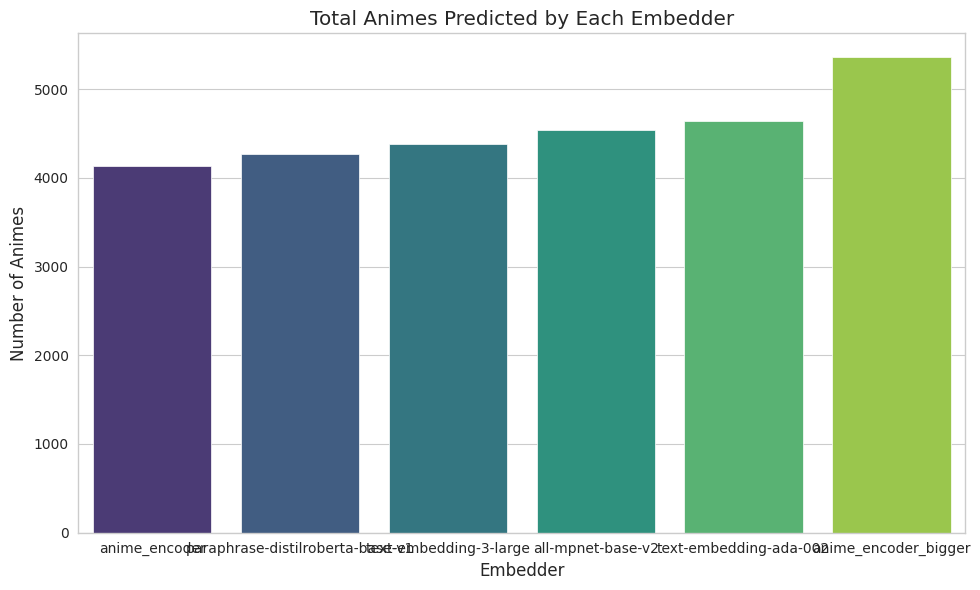

In [ ]:
total_animes_predicted = {e: set() for e in embedders}
for user_id, recs in user_preds.items():
    for embedder, rec in recs.items():
        # total_animes_predicted[embedder].update((rec.keys()))
        total_animes_predicted[embedder].update(([r[0] for r in rec]))

embedder_counts = {k: len(v) for k, v in total_animes_predicted.items()}
sorted_embedder_counts = {k: v for k, v in sorted(embedder_counts.items(), key=lambda x: x[1])}

# Creating lists for plotting the sorted data
sorted_embedders = list(sorted_embedder_counts.keys())
sorted_counts = list(sorted_embedder_counts.values())

# Plotting the sorted data
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_embedders, y=sorted_counts, palette="viridis")
plt.title("Total Animes Predicted by Each Embedder")
plt.xlabel("Embedder")
plt.ylabel("Number of Animes")
plt.tight_layout()
plt.show()

In [ ]:
rating_complete_test.head(2)

,user_id,anime_id,rating,nps_score
34576676,212268,23847,9,1
38915290,239019,14513,10,1


## 5.10 애니메이션 추천 시스템 성능 평가

In [ ]:
# Initializing list for k_values and dictionary for counts of each embedder
k_values = []
embedder_counts = defaultdict(list)
raw_counts = []

def _avg_score(scores):
    int_score = int(round(sum(scores) / len(scores)))
    return score_map[int_score]

# Creating a range of integers from 1 to 10
_r = list(range(1, 11))

# Looping over the range to get the different k values (k-factor) for recommendations
for k_factor in tqdm(_r):
    # Looping over each user and their corresponding recommendations
    for user_id, user_recs in user_preds.items():
        # Looping over each embedder and the corresponding recommendations from the embedder
        for embedder, recs_from_embedder in user_recs.items():
            # Selecting the top-k recommendations for each user from each embedder
            # final_recs = sorted(recs_from_embedder, key=lambda x: x[1], reverse=True)[:k_factor]
            # print(final_recs)

            # Looping over the top-k recommendations
            for index, (recommended_anime_id, recommendation_score) in enumerate(recs_from_embedder):
                # Fetching the user rating for the recommended anime
                user_rating = user_anime_test_ratings.get(int(user_id), {}).get(int(recommended_anime_id))

                # print(f'User {user_id} has a rating of {user_rating} for anime {recommended_anime} from embedder {embedder}')

                # Checking if the user has a rating for the recommended anime
                if user_rating is not None:
                    avg_score = sum(recommendation_score) / len(recommendation_score)
                    raw_counts.append(
                        {
                            'nps_score': score_map[user_rating], 'index': index,
                            'user_id': user_id, 'anime_id': recommended_anime_id,
                            'embedder': embedder, 'rating': user_rating,
                            'count': len(recommendation_score), 'score': avg_score
                            }
                        )
                    # The score of each recommendation is adjusted by its rank and added to the embedder_counts dictionary
                    embedder_counts[embedder].append((_avg_score(recommendation_score) * (k_factor - index) / k_factor))

    # Calculating the average Net Promoter Score (NPS) for each embedder and adding it to the k_values list
    k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
raw_counts[:2]

[{'nps_score': 1,
  'index': 1,
  'user_id': 239019,
  'anime_id': 14513,
  'embedder': 'paraphrase-distilroberta-base-v1',
  'rating': 10,
  'count': 2,
  'score': 0.6124999821186066},
 {'nps_score': 1,
  'index': 6,
  'user_id': 157681,
  'anime_id': 10087,
  'embedder': 'text-embedding-ada-002',
  'rating': 10,
  'count': 7,
  'score': 0.8862857142857142}]

In [ ]:
raw_counts_df = pd.DataFrame(raw_counts).drop_duplicates().reset_index()

# remove recs with only a single recommendation count to inspect the stronger signals
# raw_counts_df = raw_counts_df[raw_counts_df['count'] > 1]

print(raw_counts_df.shape)
raw_counts_df.tail()

(317250, 9)


,level_0,nps_score,index,user_id,anime_id,embedder,rating,count,score
317245,317245,1,5,261107,4282,text-embedding-ada-002,10,3,0.886000
317246,317246,1,2,261107,4282,text-embedding-3-large,10,3,0.709000
317247,317247,1,3,261107,4282,all-mpnet-base-v2,10,3,0.701000
317248,317248,1,5,261107,4282,anime_encoder_bigger,10,3,0.643667
317249,317249,1,2,76921,8769,all-mpnet-base-v2,9,4,0.784000


embedder
paraphrase-distilroberta-base-v1    0.829061
anime_encoder                       0.874422
all-mpnet-base-v2                   0.883831
text-embedding-3-large              0.895893
text-embedding-ada-002              0.902171
anime_encoder_bigger                0.905438
Name: nps_score, dtype: float64


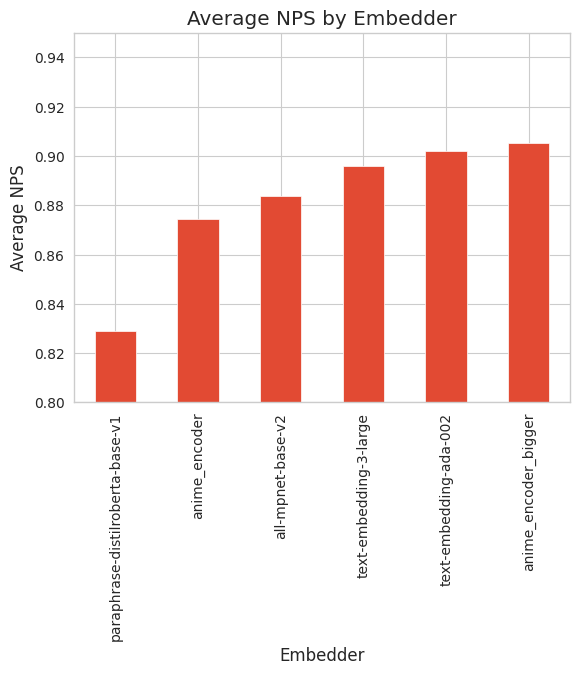

In [ ]:
# Grouping by 'embedder' and calculating mean of 'rating'
grouped_data = raw_counts_df.groupby('embedder')['nps_score'].mean().sort_values()
print(grouped_data)

# Plotting the data
grouped_data.plot(
    kind='bar',
    ylim=(.8, .95)
    )
plt.title('Average NPS by Embedder')
plt.ylabel('Average NPS')
plt.xlabel('Embedder')
plt.show()


embedder
paraphrase-distilroberta-base-v1    9.113887
anime_encoder                       9.227505
all-mpnet-base-v2                   9.270251
text-embedding-3-large              9.298831
text-embedding-ada-002              9.306445
anime_encoder_bigger                9.325051
Name: rating, dtype: float64


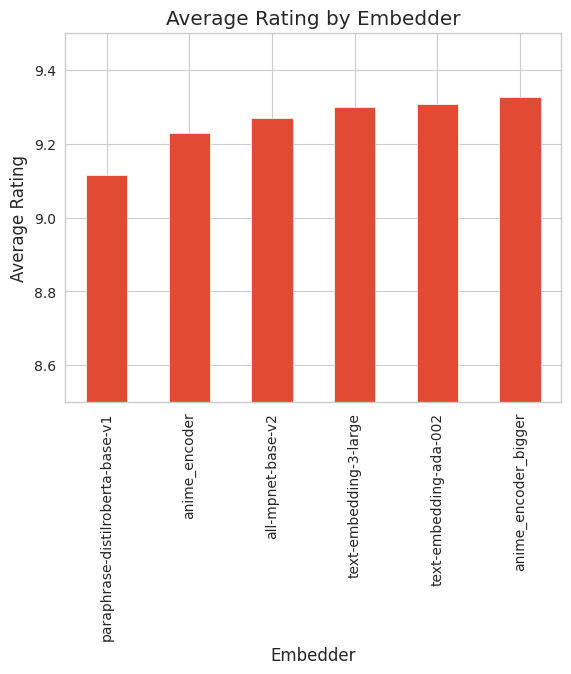

In [ ]:
# Grouping by 'embedder' and calculating mean of 'rating'
grouped_data = raw_counts_df.groupby('embedder')['rating'].mean().sort_values()
print(grouped_data)

# Plotting the data
grouped_data.plot(
    kind='bar',
    ylim=(8.5, 9.5)
    )
plt.title('Average Rating by Embedder')
plt.ylabel('Average Rating')
plt.xlabel('Embedder')
plt.show()


<Figure size 1200x600 with 0 Axes>

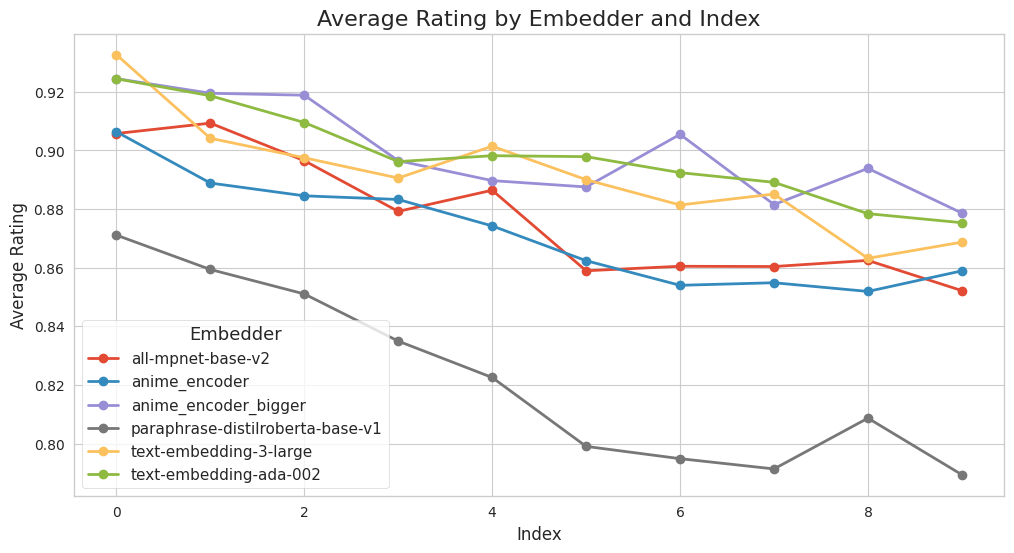

In [ ]:
# Use Seaborn style for nice looking plots
sns.set_style("whitegrid")

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(12, 6))

# Group, calculate mean, and plot while specifying line width and marker style for better visibility
ax = raw_counts_df.groupby(['embedder', 'index'])['nps_score'].mean().unstack(0).plot(
    lw=2, # Line width
    marker='o', # Marker style
    figsize=(12, 6), # Figure size
    )

# Add a title to the plot
ax.set_title('Average Rating by Embedder and Index', fontsize=16)

# Label the axes for better understanding of the plot
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Average Rating', fontsize=12)

# Adjust the legend to not block the plot and improve readability
ax.legend(title='Embedder', title_fontsize='13', fontsize='11', loc='best')

# Show the plot
plt.show()


<Axes: xlabel='index'>

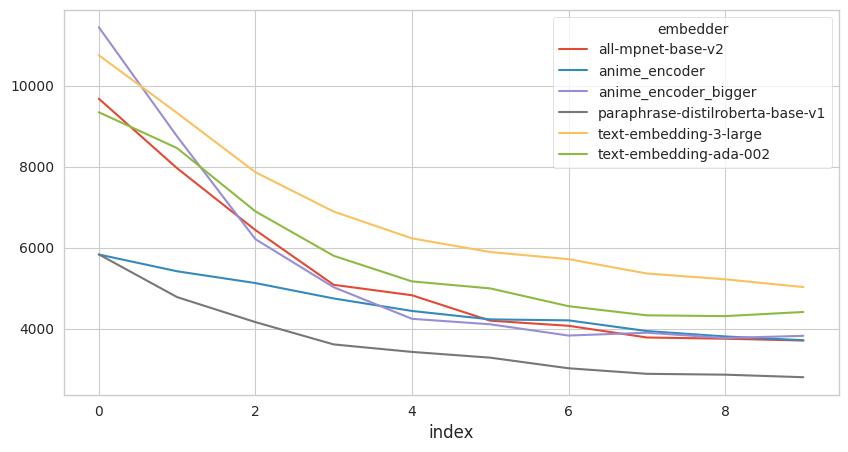

In [ ]:
# This is interesting, our encoder is giving out more recommendations found in the test set, implying that not only
# is our fine-tuned embedder getting a better average NPS score, it's giving out more recommendations than OpenAI's embedder
raw_counts_df.groupby(['embedder', 'index'])['nps_score'].count().unstack(0).plot(figsize=(10, 5))

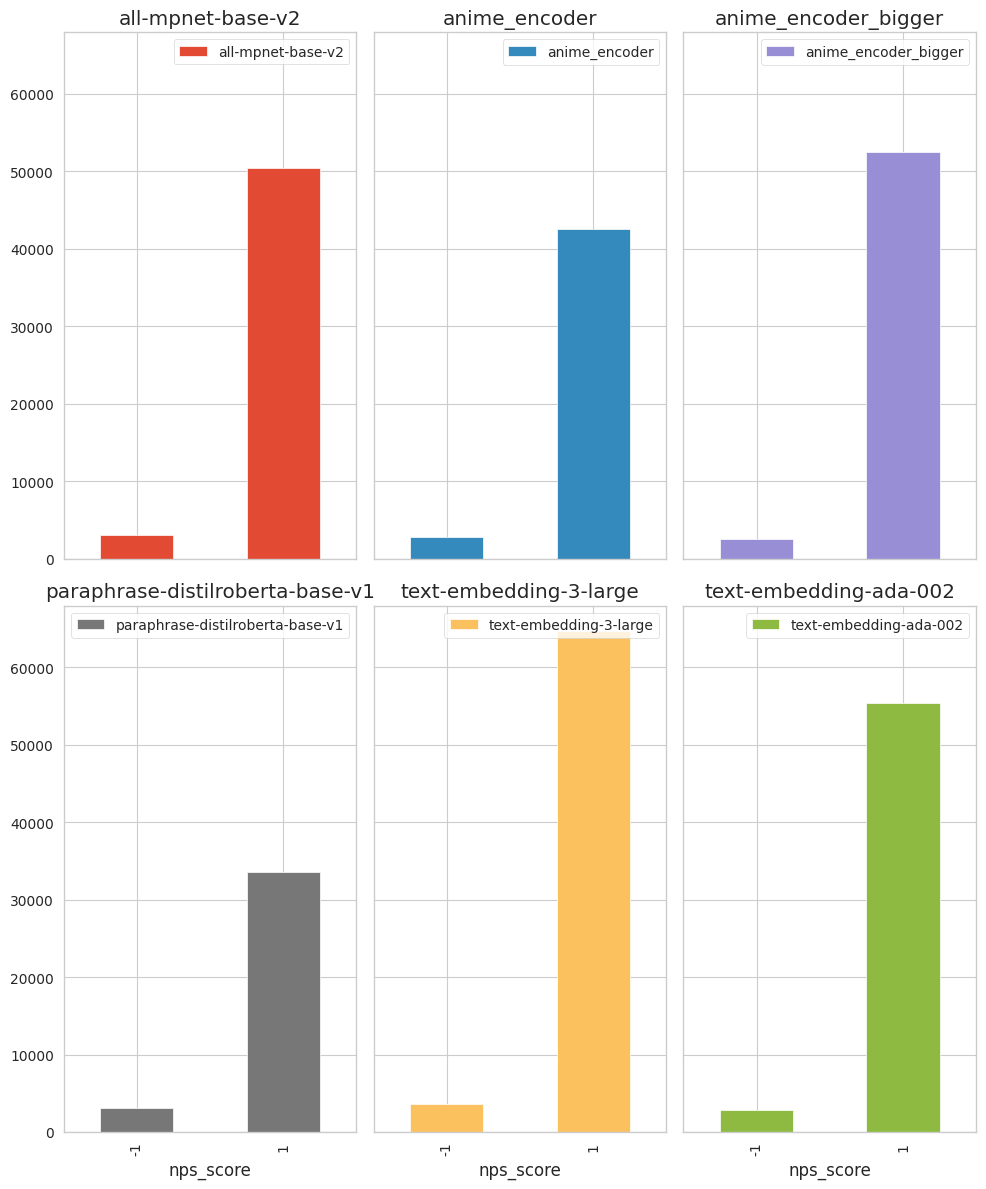

In [ ]:
# Grouping and counting
grouped = raw_counts_df.groupby('embedder')['nps_score'].value_counts().unstack(0).fillna(0)

# Plotting
grouped.plot(kind='bar', subplots=True, layout=(2, 3), figsize=(10, 12), sharex=True, sharey=True)
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

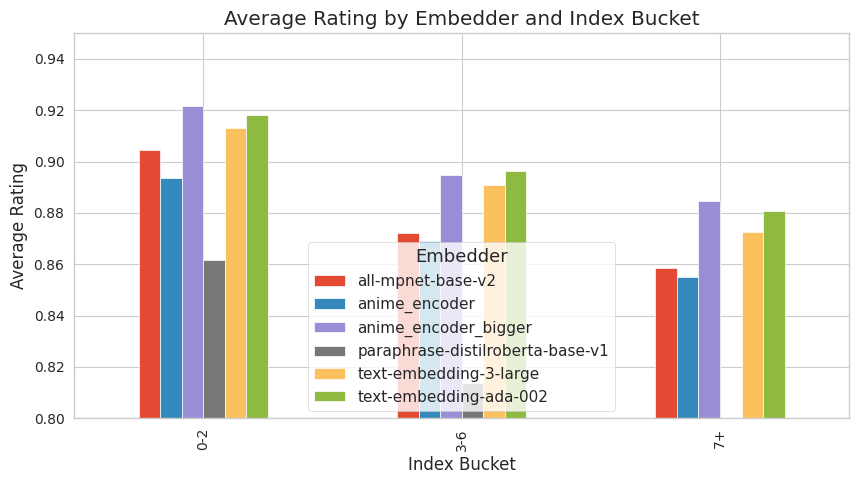

In [ ]:
# Adjusting the provided code to fix the issue and generate the desired plot

# Assuming 'raw_counts_df' already has 'index' and 'rating' columns
# Adding a new column 'index_bucket' based on the conditions provided
raw_counts_df['index_bucket'] = raw_counts_df['index'].apply(
    lambda x: '0-2' if x < 3 else '3-6' if x < 7 else '7+'
)

# Grouping by 'embedder' and 'index_bucket', then calculating the mean rating
grouped_df = raw_counts_df.groupby(["embedder", "index_bucket"])["nps_score"].mean().unstack(0)

# Plotting
plt.figure(figsize=(10, 5))
ax = grouped_df.plot(kind='bar', figsize=(10, 5))

# Setting the minimum y-value (ymin) to 8
ax.set_ylim(bottom=.8, top=.95)

plt.title('Average Rating by Embedder and Index Bucket')
plt.xlabel('Index Bucket')
plt.ylabel('Average Rating')
# put the key below the graph
ax.legend(title='Embedder', title_fontsize='13', fontsize='11', loc='lower center')
plt.show()

# Towards the later recommendations, our fine-tuned embedder is performing better

In [ ]:
grouped_df

embedder,all-mpnet-base-v2,anime_encoder,anime_encoder_bigger,paraphrase-distilroberta-base-v1,text-embedding-3-large,text-embedding-ada-002
index_bucket,,,,,,
0-2,0.904461,0.893734,0.921512,0.861658,0.913240,0.918296
3-6,0.872249,0.868990,0.894682,0.813835,0.891059,0.896271
7+,0.858376,0.855186,0.884615,0.796491,0.872501,0.880929


In [ ]:
# TODO try actively predicting negative examples to see if they were -1 NPS